# Gaia Catalog of Nearby Stars
Look at the very handy dataset for stars within ~100pc

Using the actual SN 1987A space,time coordinates, which nearby stars have seen the event? Which could have "responded"?

How do the uncertainties in LMC & Gaia distances propgate into time uncertainties for when stars should see the SNe?

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
# import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table

import sys
sys.path.append('/Users/james/Dropbox/python/cubehelix/')
import cubehelix

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

In [4]:
# SN 1987A Properties
t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1987A')

# Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
d0 = 51.4 * u.kpc
d0_err= 1.2 * u.kpc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [5]:
print(c0_radec)
print(d0.to('pc'))

<SkyCoord (ICRS): (ra, dec) in deg
    (83.86675, -69.26974167)>
51400.0 pc


In [6]:
# https://arxiv.org/abs/2012.02061
GCNS_file = '../../lonely_stars/GCNS_cat.fits'
GCNS = Table.read(GCNS_file, format='fits')

# past me already did this, yay! 
# https://github.com/jradavenport/lonely_stars/blob/main/GCNS_KDTree.ipynb
c1 = SkyCoord(ra = GCNS['RA'] * u.degree,
              dec = GCNS['DEC'] * u.degree,
              distance= GCNS['DIST_50'] * u.kpc,
              frame='icrs')

len(GCNS)
# xyz = c1.transform_to(coord.Galactocentric)

331312

In [7]:
t1 = Time.now()
# t1 = Time({'year': 2088, 'month': 2, 'day': 23}, format='ymdhms')
dt = t1-t0

# dt.sec
# dt.jd
dt.to('year')

<Quantity 34.21553296 yr>

In [8]:
c = d0.to('lyr') / 2 # dist to foci from ellipse center
a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of ellipse
print(a-c)

d1 = (GCNS['DIST_50'] * u.kpc) # dist to GCNS stars

# OMG, astropy does the 3D distance computation between coordinates!
# need to work out how to propogate errors here, but it's pretty rad...
d2 = c1.separation_3d(c0) # dist from GCNS to SN 1987A

17.107766481291037 lyr


In [9]:
# A few things to compute for each GCNS object:

# 1. has it seen SN 1987A yet?
SNYES = d2.to('lyr').value <= (d0.to('lyr') + (dt.to('s') * const.c)).to('lyr').value
SNNO = ~SNYES

# 2. is it within the "SETI ellipse"?
EYES = (d1.to('lyr').value + d2.to('lyr').value) <= (2 * a.to('lyr').value)
ENO = ~EYES

# 3. is it within some tolerance of being ON the ellipse?
#    this could be within some range in distance or in time, thanks to speed of light...
tol = 0.1 # in lyr
OYES = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= tol

In [10]:
print(len(d1))
print(sum(SNYES), sum(SNNO), sum(EYES), sum(OYES))
print(sum(SNYES) / (sum(SNYES) + sum(SNNO)))

331312
191706 139606 25091 153
0.5786267928719757


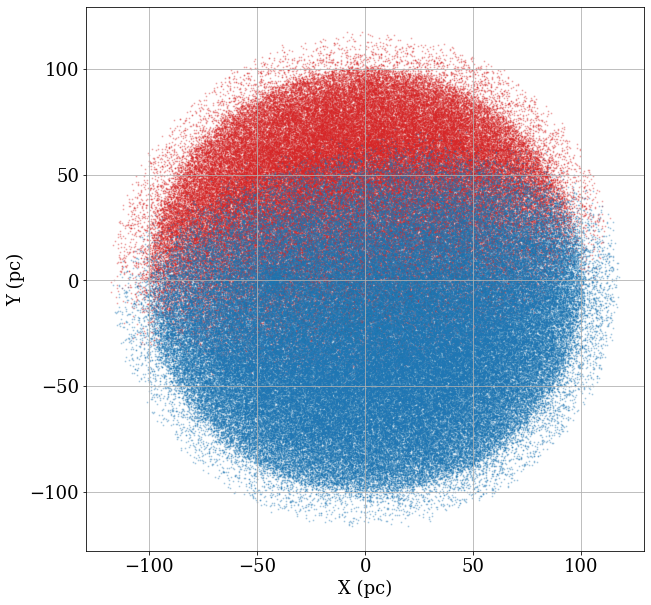

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(GCNS['XCOORD_50'][SNNO], GCNS['YCOORD_50'][SNNO], c='C3', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['XCOORD_50'][SNYES],GCNS['YCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=10, alpha=0.75, rasterized=True)

plt.xlabel('X (pc)')
plt.ylabel('Y (pc)')
plt.grid(True)
plt.savefig('GCNS_SN1987A_seenXY.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

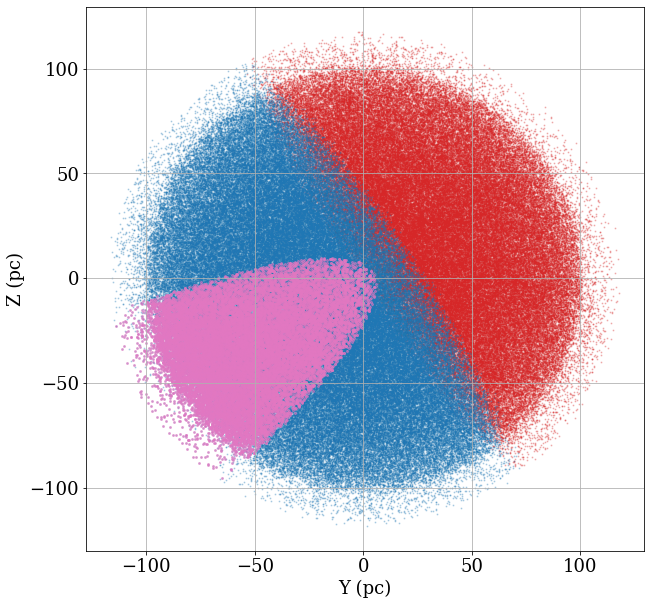

In [12]:
plt.figure(figsize=(10,10))
plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=10, alpha=0.75, rasterized=True)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
plt.grid(True)
plt.savefig('GCNS_SN1987A.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

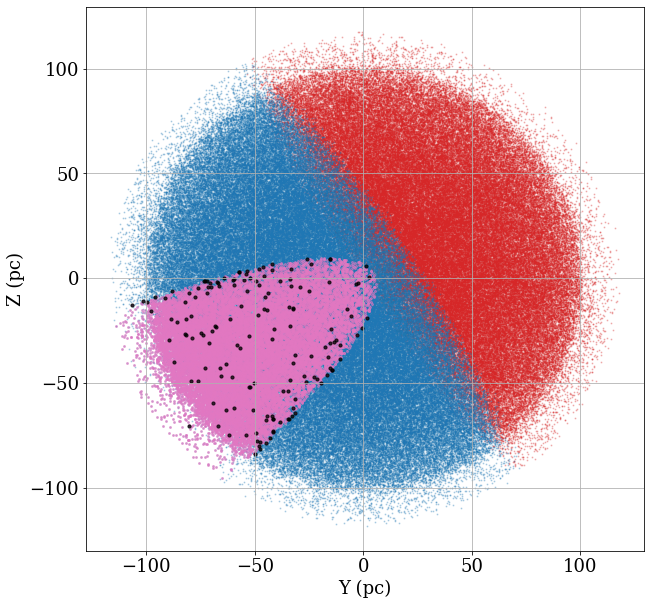

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=10, alpha=0.75, rasterized=True)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
plt.grid(True)
plt.savefig('GCNS_SN1987A_on.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [13]:
# functions for drawing ellipses and circles to scale, BUT NOT ROTATED
# b/c I'm lazy...
def echoxy0(t, c, Ntheta=1000, foci=False):
    '''
    t: time since SNe in years
    c: half the dist to the SNe in lightyears
    '''

    a = 0.5 * (t + np.sqrt(t**2 + 4 * (c**2)))
    b = np.sqrt(0.5 * (t**2 + np.sqrt(t**4 + 4 * t**2 * c**2)))
    
    if foci:
#         foci_length = np.sqrt(np.abs(a**2 - b**2))
        fx = np.array([-c, c]) - c
        fy = np.array([0.,0.])
        return fx* u.lyr, fy* u.lyr

    else:
        theta = np.linspace(0, 2*np.pi, Ntheta) # the angle about the origin

        x = a * np.cos(theta) - c
        y = b * np.sin(theta)
        return x * u.lyr, y * u.lyr
    
    
def circxy0(t, c, Ntheta=1000):
    '''
    t: time since SNe in years
    c: half the dist to the SNe in lightyears
    '''
    a = 0.5 * (t + np.sqrt(t**2 + 4 * (c**2)))
    da = np.abs(a - c)
    acirc = a + da + c
    print(acirc, 2*c+t)
    theta = np.linspace(0, 2*np.pi, Ntheta) # the angle about the origin
    x = acirc * np.cos(theta) - 2*c
    y = acirc * np.sin(theta)

    return x * u.lyr, y * u.lyr

167678.5971709939 167678.59367936864


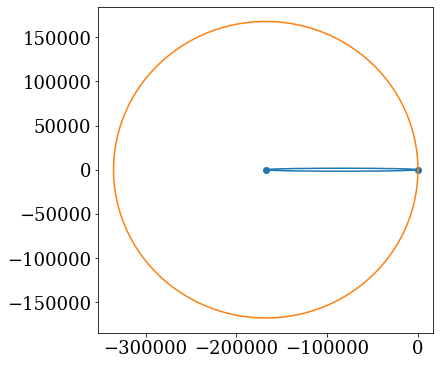

In [14]:
t=dt.to('year').value
fx0,fy0 = echoxy0(t, c.value, foci=True)
fx,fy = echoxy0(t, c.value, Ntheta=10000)
cx,cy = circxy0(t, c.value, Ntheta=10000)

plt.figure(figsize=(6,6))
plt.scatter(fx0, fy0)
plt.plot(fx, fy)
plt.plot(cx, cy)

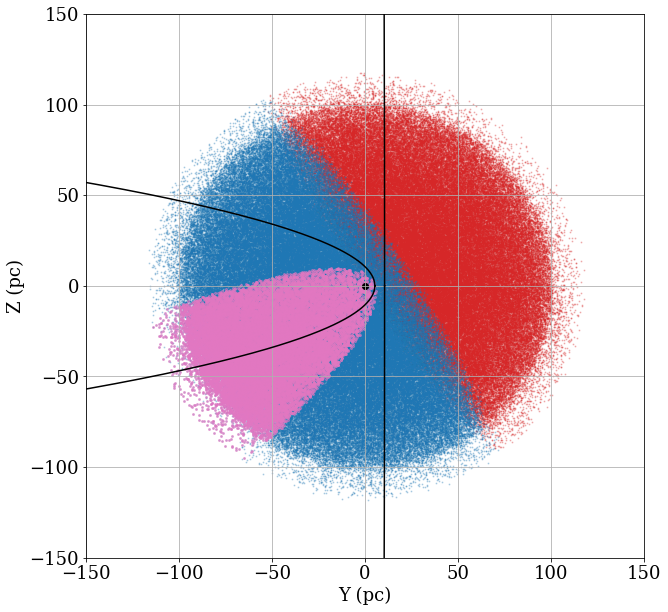

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.25)
plt.scatter(GCNS['YCOORD_50'][SNYES], GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25)

plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5)

plt.scatter((fx0).to('pc'), fy0.to('pc'), c='k')
plt.plot((fx).to('pc'), fy.to('pc'), c='k')
plt.plot((cx).to('pc'), cy.to('pc'), c='k')
plt.xlim(-150,150)
plt.ylim(-150,150)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
plt.grid(True)


(-100.0, 100.0)

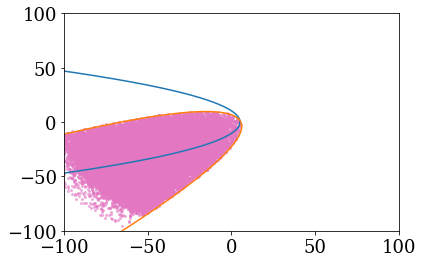

In [16]:
xpos = (fx - fx0[1]).to('pc')
ypos = fy.to('pc')
ang = np.deg2rad(-32.75)

new_xpos = xpos * np.cos(ang)+ypos*np.sin(ang)
new_ypos = -xpos * np.sin(ang)+ypos*np.cos(ang)
plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5)

plt.plot(xpos, ypos)
plt.plot(new_xpos, new_ypos)
plt.xlim(-100,100)
plt.ylim(-100,100)

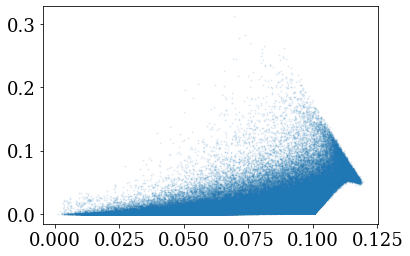

In [17]:
plt.scatter(GCNS['DIST_50'], (GCNS['DIST_84'] - GCNS['DIST_50'])/GCNS['DIST_50'], s=1, alpha=0.1)